## Static cascade, just using numpy
MADE BIG CHANGE IN SPREAD(), REDUCE ORIGINAL (NOT CURRENT) OUTPUT BY FRACTION (CURRENT INPUT/TOTAL REQUIREMENT)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import animation,rc
from IPython.display import HTML

%matplotlib inline

In [2]:
trm18 = pd.read_csv("IxI_18.csv", index_col=0) #total requirements matrix
trm18_mat = trm18.to_numpy() # just a numpy version of the trm, if needed?
back_link18 = trm18.sum(axis=0) # backwards links or total input requirements

def shock(industry, beta, gamma_c):
    
    global cascade #this is the current state of the network at any stage in sim
    global fail_list #current list of all failed industries at any stage in sim
    fail_list = []
    cascade = trm18_mat.copy()
    
    for i in range(0,len(cascade)):
        cascade[industry][i] = beta*cascade[industry][i] #initial shock
    
    spread(gamma_c)

In [3]:
def spread(gamma_c):
    
    prev_number_fail = len(fail_list) #this will compare num. failed in consecutive stages, if different, proceed
    #print(fail_list)
    current_backlink = cascade.sum(axis=0) #column sums
    
    for i in range(0,len(cascade)):
        gamma = current_backlink[i]/back_link18[i] #reduce output by fraction of input
        for j in range(0,len(cascade)):
            if (1-gamma) > gamma_c:
                cascade[i][j] = 0
                if i not in fail_list:
                    fail_list.append(i)
            else:
                #cascade[i][j] = gamma*cascade[i][j] #?? reduce current output by gamma, or reduce original output by gamma
                cascade[i][j] = gamma*trm18_mat[i][j]
                
    current_fail = len(fail_list)
    #print(fail_list)
            
    check(prev_number_fail,current_fail,gamma_c)
    
def check(prev_number_fail, current_fail, gamma_c):
    
    global frac_survived
    
    if (prev_number_fail == current_fail):
        frac_survived = (1-current_fail/len(cascade))
        #print("------------Simulation Over--------------")
        #print("")
    elif len(fail_list) == len(cascade):
        frac_survived = (1-current_fail/len(cascade))
        #print("------------Simulation Over--------------")
        #print("")
    else:
        #print("------cascading-------")
        spread(gamma_c)

## Plotting

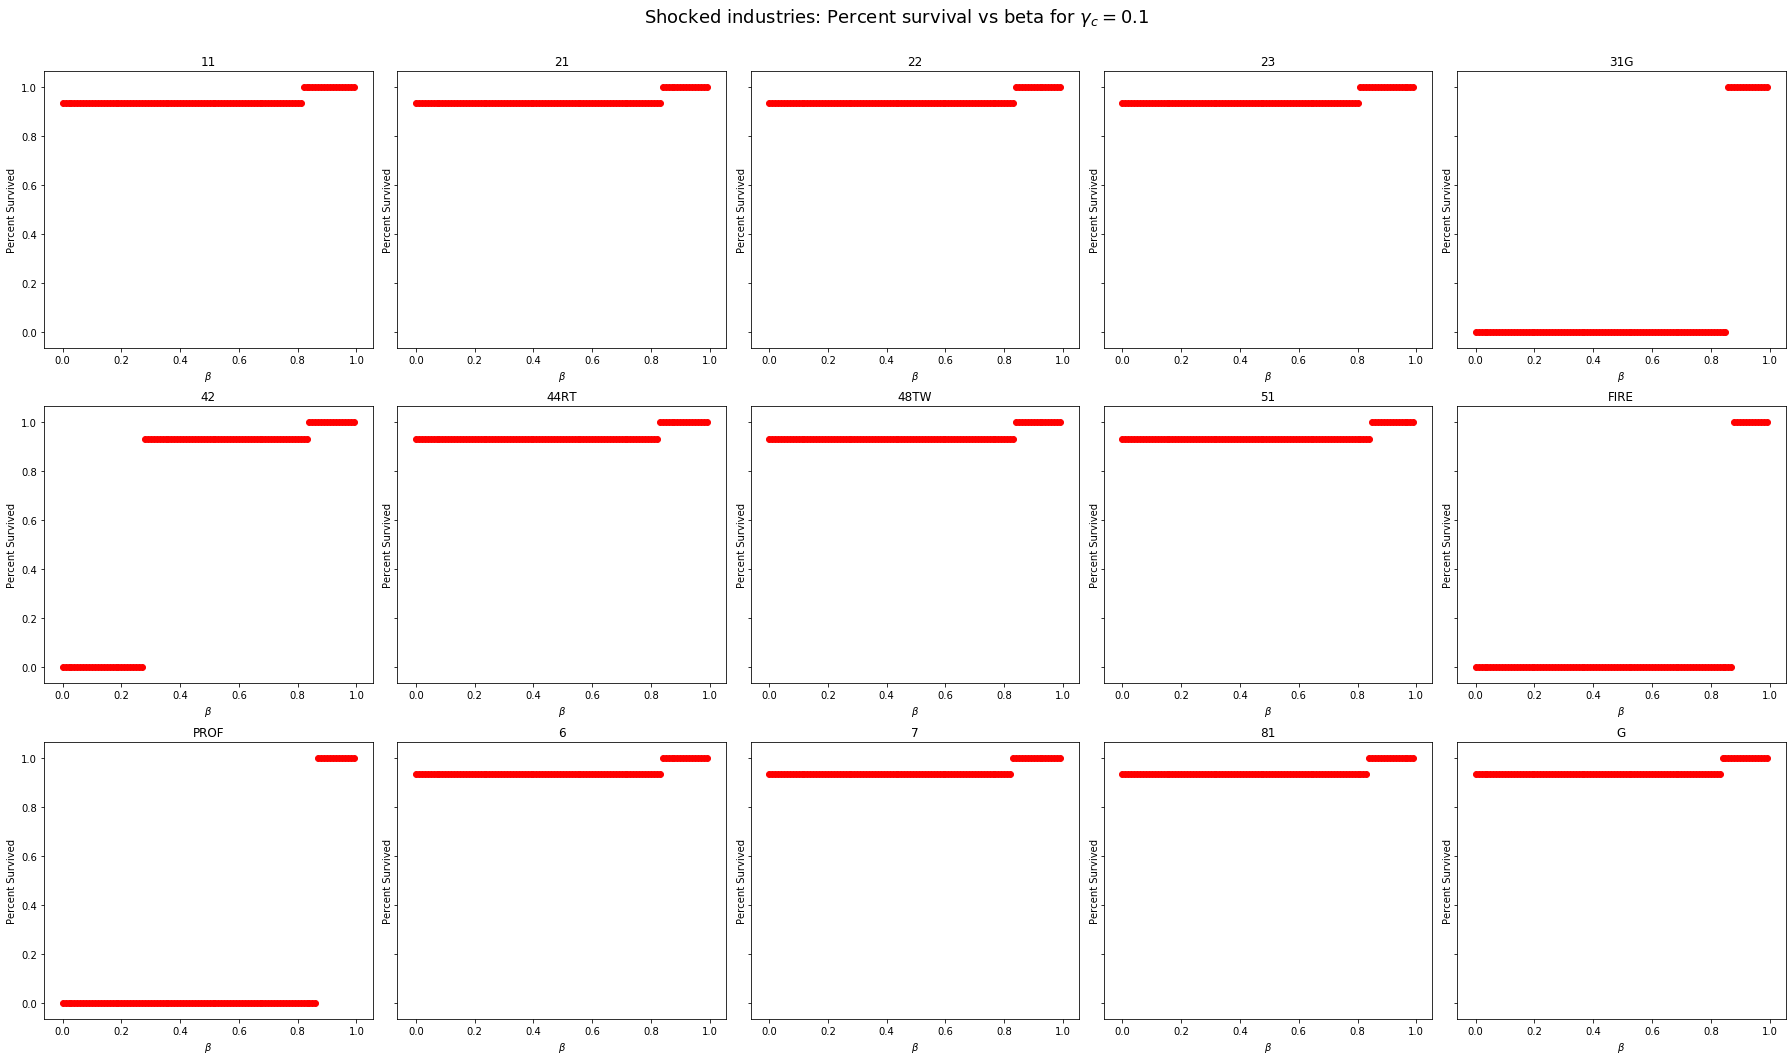

In [4]:
fig, ax = plt.subplots(3,5,figsize=(25,15),sharey=True)
    
plotlist = ([0,'11',0,0],[1,'21',0,1],[2,'22',0,2],[3,'23',0,3],[4,'31G',0,4],[5,'42',1,0],[6,'44RT',1,1],
            [7,'48TW',1,2],[8,'51',1,3]
            ,[9,'FIRE',1,4],[10,'PROF',2,0],[11,'6',2,1],[12,'7',2,2]
            ,[13,'81',2,3],[14,'G',2,4])

for (indn,ind,i,j) in plotlist:
    for beta in np.arange(0.0,1,0.01):
        shock(indn, beta, 0.1)
        ax[i][j].scatter(beta,frac_survived,color='red')
    ax[i][j].set_title(ind)
    ax[i][j].set_ylabel("Percent Survived")
    ax[i][j].set_xlabel(r'$\beta$')

plt.tight_layout()
fig.subplots_adjust(top=0.92)
fig.suptitle("Shocked industries: Percent survival vs beta for " r'$\gamma_c = 0.1$',fontsize=18)
plt.show()

## animated plot


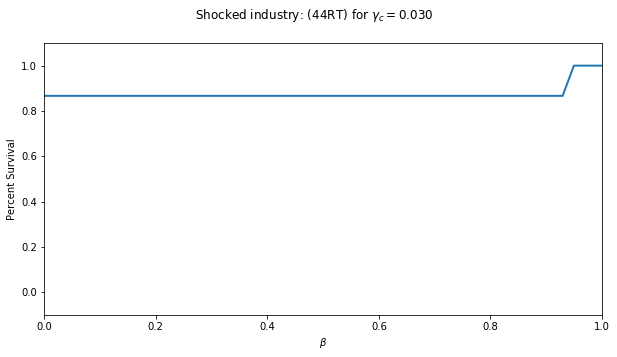

In [272]:
fig1, ax1 = plt.subplots(figsize=(10,5))
ax1.set_xlim(0,1)
ax1.set_ylim(-0.1,1.1)
ax1.set_xlabel(r'$\beta$')
ax1.set_ylabel("Percent Survival")
x,y = [],[]
line, = ax1.plot([], [], lw=2)

def init():
    line.set_data([], [])
    return (line,)

def animate(i):
    x = []
    y = []
    for beta in np.linspace(0,1,100):
        shock(6,beta,i) # choose industry to shock
        x.append(beta)
        y.append(frac_survived)
    line.set_data(x, y)
    fig1.suptitle("Shocked industry: (44RT) for " + r'$\gamma_c = %.3f$' % i)
    return (line,)
    
anim = animation.FuncAnimation(fig1, animate, init_func=init,
                               frames=np.linspace(0.02,0.03,100), interval=100, blit=True)

rc('animation', html='html5')
HTML(anim.to_html5_video())

#anim.save("31G.mp4")

## interesting cascade

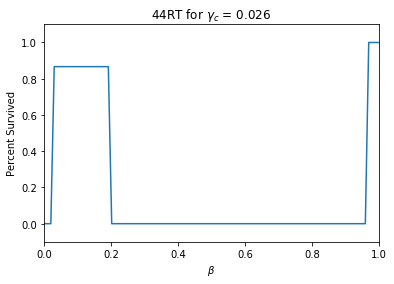

In [270]:
x, y = [],[]

for beta in np.linspace(0,1,100):
    shock(6,beta,0.02335) #in range gamma_c = 0.0229 - 0.028 ish for industry 6 (44RT)
    x.append(beta)
    y.append(frac_survived)
    
plt.xlim(0,1)
plt.ylim(-0.1,1.1)
plt.title("44RT for $\gamma_c$ = 0.026")
plt.xlabel(r'$\beta$')
plt.ylabel("Percent Survived")
    
plt.plot(x,y)

In [247]:
shock(6,0.2,0.026) # (industry, beta, gamma_c)

## Quantifying damage

In [4]:
damage = [0]*15
area = 0

for i in range(0,15):
    for gc in np.linspace(0,1,101): #gamma_c range, anything above gc = 0.5 is pretty much a line at 1 anyways
        for beta in np.linspace(0,1,101):
            shock(i,beta,gc)
            area += (1-frac_survived)*0.01
        damage[i] += area
        area = 0

### Ranked Scores

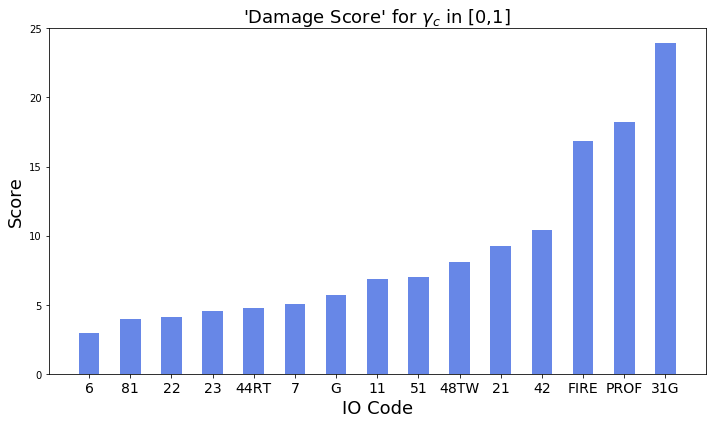

In [5]:
index = ['11', '21', '22', '23', '31G', '42', '44RT', '48TW', '51', 'FIRE', 'PROF', '6', '7', '81', 'G']

ranking = [];
score_list_ranked = [];
index_list_ranked = [];

for i in range(0,15):
    ranking.append((damage[i],index[i])) #create list of (safety score, industry)
    
ranking.sort(key=lambda x: x[0]) # sorts the ranking list (safety score, industry) by score
#ranking = ranking[::-1] # sorts in descending order

for (s,i) in ranking:
    score_list_ranked.append(s)
    index_list_ranked.append(i)

fig, (ax1) = plt.subplots(1,1,figsize=(10,6))
x = np.arange(len(index))
bar_width = 0.5
opacity = 0.8

rects1 = ax1.bar(x, score_list_ranked, bar_width, 
alpha=opacity, 
color='royalblue')

ax1.set_xlabel('IO Code', fontsize=18)
ax1.set_ylabel('Score', fontsize=18)
ax1.set_title("'Damage Score' for $\gamma_c$ in [0,1]", fontsize=18)
ax1.set_xticks(x)
ax1.set_xticklabels(index_list_ranked,fontsize=14)
plt.ylim(0,25)

plt.tight_layout()
plt.show()

### Is forward link ranking the same as damage score?
turns out, no! the largest producers are also the most damaging, but there's variation in the smaller production industries

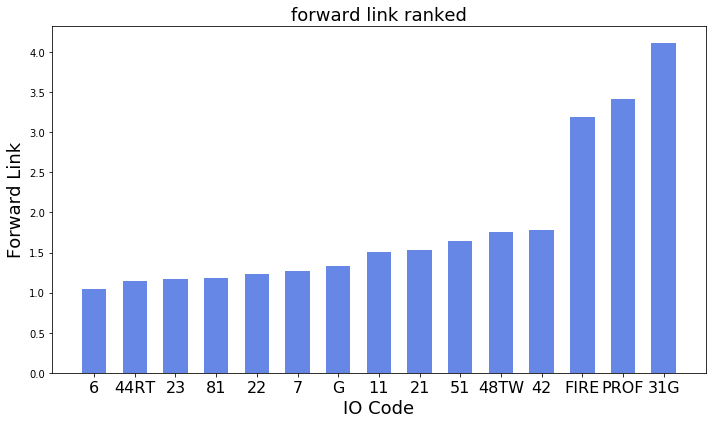

In [20]:
index = ['11', '21', '22', '23', '31G', '42', '44RT', '48TW', '51', 'FIRE', 'PROF', '6', '7', '81', 'G']
forwlink = []
forw_list_rank = []
index_list_rank = []
for i in range(0,15):
    forwlink.append((trm18.sum(axis=1)[i],index[i]))

forwlink.sort(key=lambda x: x[0]) # sorts the ranking list (safety score, industry) by score

for (s,i) in forwlink:
    forw_list_rank.append(s)
    index_list_rank.append(i)

fig, (ax2) = plt.subplots(1,1,figsize=(10,6))
x = np.arange(len(index))
bar_width = 0.6
opacity = 0.8

rects2 = ax2.bar(x, forw_list_rank, bar_width, 
alpha=opacity, 
color='royalblue')

ax2.set_xlabel('IO Code', fontsize=18)
ax2.set_ylabel('Forward Link', fontsize=18)
ax2.set_title("forward link ranked", fontsize=18)
ax2.set_xticks(x)
ax2.set_xticklabels(index_list_rank,fontsize=16)

plt.tight_layout()
plt.show()

### what changed between score ranking and forward link ranking?

In [7]:
ind_rank = [j for (x,j) in ranking]
ind_forwlink = [j for (x,j) in forwlink]
compare_rank = np.array(ind_forwlink+ind_rank).reshape(2,15)

In [8]:
#this prints how an industries rank changes between forward link and damage score. a positive means it's more
# 'dangerous' than forward link suggests

# want to look at 44RT and 21, who are they connected to such that their damage is much stronger than forward link

for i in range(15):
    if compare_rank[0][i] == compare_rank[1][i]:
        print(compare_rank[0][i] + ": same rank")
    else:
        for j in range(15):
            if compare_rank[0][i] == compare_rank[1][j]:
                diff = j-i
                print(compare_rank[0][i] + ": %.1f" % diff + " in damage rank" )

6: same rank
44RT: 3.0 in damage rank
23: 1.0 in damage rank
81: -2.0 in damage rank
22: -2.0 in damage rank
7: same rank
G: same rank
11: same rank
21: 2.0 in damage rank
51: -1.0 in damage rank
48TW: -1.0 in damage rank
42: same rank
FIRE: same rank
PROF: same rank
31G: same rank


### Damage score effected primarily by forward link, but can shift due to non-uniformity of outputs

In [9]:
overall_rank = []
largest_link_pct = [] # largest entry of each row in pct_output_mat
pct_output_mat = np.zeros((15,15)) #each entry is percent of total intermediate output given from i --> j
forw_link = trm18.sum(axis=1)

for i in range(15):
    for j in range(15): 
        pct_output_mat[i][j] = trm18_mat[i][j]/forw_link[i]
        
pct_output_mat.sort(axis=1)

for i in range(15):
    largest_link_pct.append(pct_output_mat[i][-2])
    overall_rank.append((index[i],trm18.sum(axis=1)[i],largest_link_pct[i]))
    
overall_rank.sort(key=lambda x: x[1])

overall_rank #(industry, forward link, largest link % of forward link)


[('6', 1.0389793999999999, 0.007603904370000023),
 ('44RT', 1.1407087000000005, 0.048969469593770944),
 ('23', 1.1735514000000005, 0.025540168074444796),
 ('81', 1.1877407, 0.016501665725524098),
 ('22', 1.2315522999999997, 0.017697177781244047),
 ('7', 1.2665708, 0.028562398564691373),
 ('G', 1.3367326, 0.03608664889297979),
 ('11', 1.5054041999999996, 0.05835861225842204),
 ('21', 1.5365381000000002, 0.07624581518675),
 ('51', 1.6486930000000002, 0.033203270712012484),
 ('48TW', 1.7561089999999997, 0.04274683405187264),
 ('42', 1.7748287999999999, 0.08476479534251416),
 ('FIRE', 3.1954259, 0.062356632960883236),
 ('PROF', 3.4126054, 0.06371255229215778),
 ('31G', 4.1144508, 0.09611737245709684)]

## Heatmap, should give stable/unstable zones

In [7]:
fracsurvive = []
delta = 201
gammacut = 1
ind = 6

for gc in np.linspace(0,gammacut,delta):
    for beta in np.linspace(0,1,delta):
        shock(ind,beta,gc)
        fracsurvive.append(frac_survived)
        
fracsurvive = np.array(fracsurvive).reshape(delta,delta)

In [8]:
df = pd.DataFrame(fracsurvive, columns = np.linspace(0,1,delta), index=np.linspace(0,gammacut,delta))
df1 = pd.DataFrame(df.iloc[0:,0:], columns = np.linspace(0,1,delta), index=np.linspace(0,gammacut,delta))

Text(0.5, 1, 'Stable/Unstable regions for 31G')

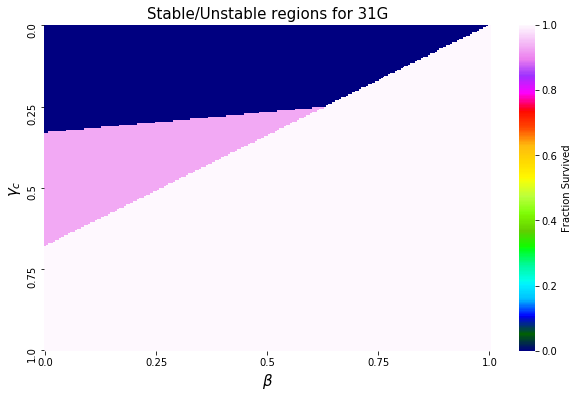

In [10]:
dict = {'0':'11','1':'21','2':'22','3':'23','4':'31G','5':'42','6':'44RT',
        '7':'48TW','8':'51','9':'FIRE','10':'PROF','11':'6','12':'7','13':'81','14':'G'}

cmap = sns.cubehelix_palette(18, start=2, rot=4, dark=0, light=0.7, reverse=True)
cmap1 = 'gist_ncar'
plt.figure(figsize=(10,6))
ax=sns.heatmap(df1,cmap=cmap1,xticklabels=50,yticklabels=50,cbar_kws={'label': 'Fraction Survived'})
ax.set_xlabel(r'$\beta$',fontsize=15)
ax.set_ylabel(r'$\gamma_c$',fontsize=15)
ax.set_title("Stable/Unstable regions for " + dict['%d' % ind],fontsize=15)

In [11]:
np.linspace(0,1,201)

array([0.   , 0.005, 0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 ,
       0.045, 0.05 , 0.055, 0.06 , 0.065, 0.07 , 0.075, 0.08 , 0.085,
       0.09 , 0.095, 0.1  , 0.105, 0.11 , 0.115, 0.12 , 0.125, 0.13 ,
       0.135, 0.14 , 0.145, 0.15 , 0.155, 0.16 , 0.165, 0.17 , 0.175,
       0.18 , 0.185, 0.19 , 0.195, 0.2  , 0.205, 0.21 , 0.215, 0.22 ,
       0.225, 0.23 , 0.235, 0.24 , 0.245, 0.25 , 0.255, 0.26 , 0.265,
       0.27 , 0.275, 0.28 , 0.285, 0.29 , 0.295, 0.3  , 0.305, 0.31 ,
       0.315, 0.32 , 0.325, 0.33 , 0.335, 0.34 , 0.345, 0.35 , 0.355,
       0.36 , 0.365, 0.37 , 0.375, 0.38 , 0.385, 0.39 , 0.395, 0.4  ,
       0.405, 0.41 , 0.415, 0.42 , 0.425, 0.43 , 0.435, 0.44 , 0.445,
       0.45 , 0.455, 0.46 , 0.465, 0.47 , 0.475, 0.48 , 0.485, 0.49 ,
       0.495, 0.5  , 0.505, 0.51 , 0.515, 0.52 , 0.525, 0.53 , 0.535,
       0.54 , 0.545, 0.55 , 0.555, 0.56 , 0.565, 0.57 , 0.575, 0.58 ,
       0.585, 0.59 , 0.595, 0.6  , 0.605, 0.61 , 0.615, 0.62 , 0.625,
       0.63 , 0.635,